In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from tensorflow .keras .applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.feature import hog
import cv2




In [2]:

def load_and_preprocess_images(data_dir, image_size=(150, 150)):
    images = []
    labels = []
    for category in ['cats', 'dogs']:
        path = os.path.join(data_dir, category)
        label = 0 if category == 'cats' else 1
        for img_file in os.listdir(path):
            try:
                img_path = os.path.join(path, img_file)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Error loading {img_file}. Skipping.")
                    continue
                img = cv2.resize(img, image_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype('uint8')
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue
    return np.array(images), np.array(labels)

In [3]:
#extrtacting various features from the image
#1.hog features
def hog_features(images):
    hog_features=[]
    for img in images:
        img_hog=hog(img,orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2),channel_axis=2)
        hog_features.append(img_hog)
    return np.array(hog_features)

#2. cnn features
def cnn_features(images):
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    processed_images=preprocess_input(np.array(images))
    features=base_model.predict(processed_images)
    return features


In [7]:
data_dir=r"C:\Users\kisho\Videos\Captures\kaggledataset\image cats and dogs"
load_and_preprocess_images(data_dir)
images, labels = load_and_preprocess_images(data_dir)
hog_features= hog_features(images)
cnn_features = cnn_features(images) 
print(hog_features.shape)
print(labels.shape)



37/37 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step
(1175, 10404)
(1175,)


In [8]:
#hyper parameter tuning with grid search

param_grid={"kernel":["linear","rbf","poly"],
            "C":[0.1,1,10]}
grid_search=GridSearchCV(SVC(),param_grid,cv=5)
grid_search.fit(hog_features,labels)
print(grid_search.best_params_) 
print(grid_search.best_score_)
best_svc=grid_search.best_estimator_
best_svc

{'C': 1, 'kernel': 'rbf'}
0.727659574468085


SVC(C=1)

In [17]:
#training the model with the hog features
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)
model=best_svc
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuarcy=accuracy_score(y_test, y_pred)
print("the accuarcy of the model with hog features is",accuarcy)
print(classification_report(y_test, y_pred))


the accuarcy of the model with hog features is 0.6893617021276596
              precision    recall  f1-score   support

           0       0.71      0.88      0.79       152
           1       0.61      0.34      0.43        83

    accuracy                           0.69       235
   macro avg       0.66      0.61      0.61       235
weighted avg       0.67      0.69      0.66       235



In [18]:
grid_search=GridSearchCV(SVC(),param_grid,cv=5)
grid_search.fit(cnn_features,labels)  
print(grid_search.best_params_)
print(grid_search.best_score_)
best_svc_cnn=grid_search.best_estimator_
best_svc_cnn

{'C': 1, 'kernel': 'rbf'}
0.9642553191489363


SVC(C=1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(cnn_features, labels, test_size=0.2, random_state=42) 
model=best_svc_cnn
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

accuarcy_cnn=accuracy_score(y_test, y_pred)
print("the accuarcy of the model with extracted CNN features is",accuarcy_cnn)
print(classification_report(y_test, y_pred))

the accuarcy of the model with extracted CNN features is 0.948936170212766
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       152
           1       0.94      0.92      0.93        83

    accuracy                           0.95       235
   macro avg       0.95      0.94      0.94       235
weighted avg       0.95      0.95      0.95       235



visualising the comparison of accuarcy score with hog and cnn features


Text(0.5, 1.0, 'accuarcy of the model')

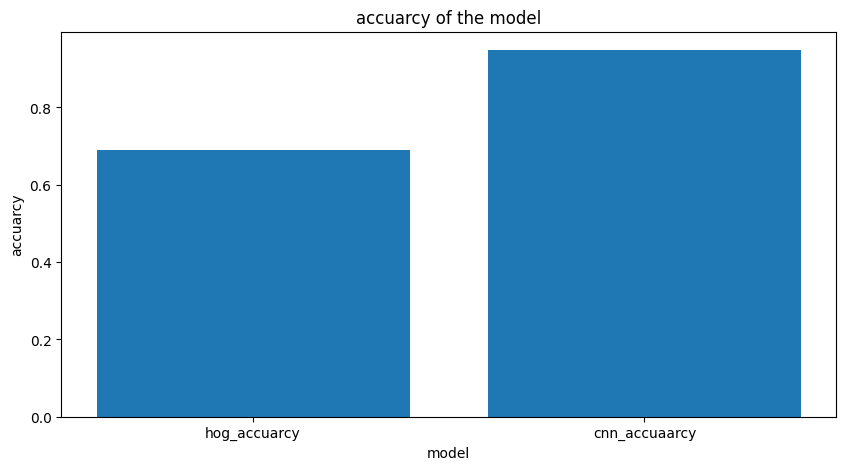

In [21]:
import matplotlib.pyplot as plt

print("visualising the comparison of accuarcy score with hog and cnn features")
plt.figure(figsize=(10,5))
plt.bar(["hog_accuarcy","cnn_accuaarcy"],[accuarcy,accuarcy_cnn])
plt.xlabel("model")
plt.ylabel("accuarcy")
plt.title("accuarcy of the model")